In [ ]:
# Run Date: Thursday, June 01, 2023
# Run Time: 00:11:25

# You must manually create the '03_03_vae_faces/output' subfolder for the generated image file.

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

# 🤪 Variational Autoencoders - CelebA Faces

In this notebook, we'll walk through the steps required to train your own variational autoencoder on the CelebA faces dataset

In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd

from utils import sample_batch, display

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

2023-06-01 15:30:59.996504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-01 15:31:00.112903: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 0. Parameters <a name="parameters"></a>

In [3]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 64
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

## 1. Prepare the data <a name="prepare"></a>

In [4]:
dataFolder = '/tf/All/Data/Documents/Github/rasbt/data/celeba'

In [5]:
# Load the data
train_data = utils.image_dataset_from_directory(
    dataFolder,
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 202599 files belonging to 1 classes.


2023-06-01 15:31:05.751428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 15:31:05.751677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 15:31:05.753519: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 15:31:05.753669: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-01 15:31:05.753809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

In [6]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

In [7]:
train_sample = sample_batch(train)

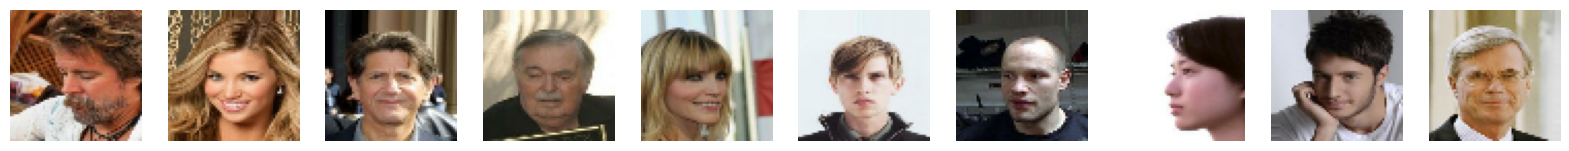

In [8]:
# Show some faces from the training set
display(train_sample, cmap=None)

## 2. Build the variational autoencoder <a name="build"></a>

In [9]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [10]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 64)   0           ['batch_normalization[0][0]

In [11]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 200)]             0         
                                                                 
 dense (Dense)               (None, 256)               51456     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 2, 2, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 4, 4, 64)         36928     
 nspose)                                                     

In [12]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [13]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [14]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [15]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="03_03_vae_faces/checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="03_03_vae_faces/logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("03_03_vae_faces/output/generated_img_%03d_%d.png" % (epoch, i))

In [16]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("03_03_vae_faces/models/vae")
    tmp = vae.predict(train.take(1))

In [17]:
%%time
vae.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

Epoch 1/10


2023-06-01 15:31:09.455627: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


1583/1583 [==============================] - ETA: 0s - loss: 102.8010 - reconstruction_loss: 69.5078 - kl_loss: 15.2263

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 68s 41ms/step - loss: 102.7896 - reconstruction_loss: 69.5078 - kl_loss: 15.2263
Epoch 2/10
1583/1583 [==============================] - ETA: 0s - loss: 71.7607 - reconstruction_loss: 55.1066 - kl_loss: 15.3209

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 71.7598 - reconstruction_loss: 55.1066 - kl_loss: 15.3209
Epoch 3/10
1583/1583 [==============================] - ETA: 0s - loss: 68.1413 - reconstruction_loss: 51.6368 - kl_loss: 16.0408

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 68.1410 - reconstruction_loss: 51.6368 - kl_loss: 16.0408
Epoch 4/10
1583/1583 [==============================] - ETA: 0s - loss: 66.7681 - reconstruction_loss: 50.1944 - kl_loss: 16.3022

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 66.7679 - reconstruction_loss: 50.1944 - kl_loss: 16.3022
Epoch 5/10
1583/1583 [==============================] - ETA: 0s - loss: 65.9618 - reconstruction_loss: 49.2700 - kl_loss: 16.4991

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 65.9616 - reconstruction_loss: 49.2700 - kl_loss: 16.4991
Epoch 6/10
1583/1583 [==============================] - ETA: 0s - loss: 65.3026 - reconstruction_loss: 48.3992 - kl_loss: 16.7309

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 65.3024 - reconstruction_loss: 48.3992 - kl_loss: 16.7309
Epoch 7/10
1583/1583 [==============================] - ETA: 0s - loss: 64.8958 - reconstruction_loss: 47.8199 - kl_loss: 16.9217

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 64.8957 - reconstruction_loss: 47.8199 - kl_loss: 16.9217
Epoch 8/10
1583/1583 [==============================] - ETA: 0s - loss: 64.6181 - reconstruction_loss: 47.5090 - kl_loss: 17.0094

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 64.6181 - reconstruction_loss: 47.5090 - kl_loss: 17.0094
Epoch 9/10
1582/1583 [============================>.] - ETA: 0s - loss: 64.4625 - reconstruction_loss: 47.2845 - kl_loss: 17.0772

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 64.4624 - reconstruction_loss: 47.2843 - kl_loss: 17.0768
Epoch 10/10
1583/1583 [==============================] - ETA: 0s - loss: 64.2781 - reconstruction_loss: 47.0408 - kl_loss: 17.1341

INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/checkpoint/assets


1583/1583 [==============================] - 65s 41ms/step - loss: 64.2781 - reconstruction_loss: 47.0408 - kl_loss: 17.1341
CPU times: user 14min 39s, sys: 43 s, total: 15min 22s
Wall time: 10min 52s


In [18]:
# Save the final models
vae.save("03_03_vae_faces/models/vae")
encoder.save("03_03_vae_faces/models/encoder")
decoder.save("03_03_vae_faces/models/decoder")

INFO:tensorflow:Assets written to: 03_03_vae_faces/models/vae/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/models/vae/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/models/encoder/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/models/encoder/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/models/decoder/assets


INFO:tensorflow:Assets written to: 03_03_vae_faces/models/decoder/assets


## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [19]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 0s 4ms/step
Example real faces


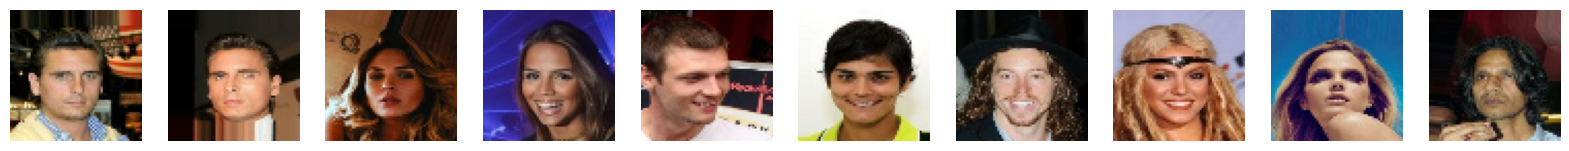

Reconstructions


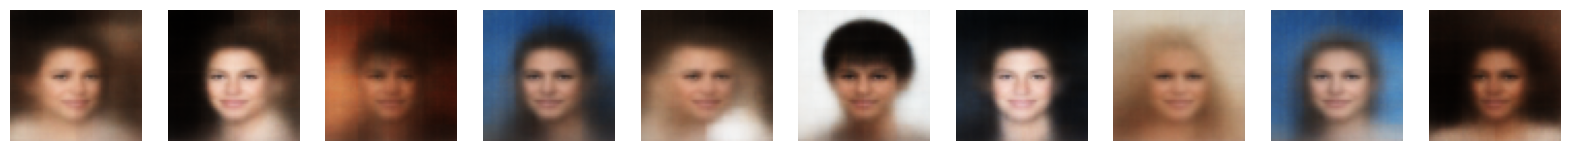

In [20]:
# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
display(example_images)
print("Reconstructions")
display(reconstructions)

## 4. Latent space distribution

4/4 [==============================] - 0s 2ms/step


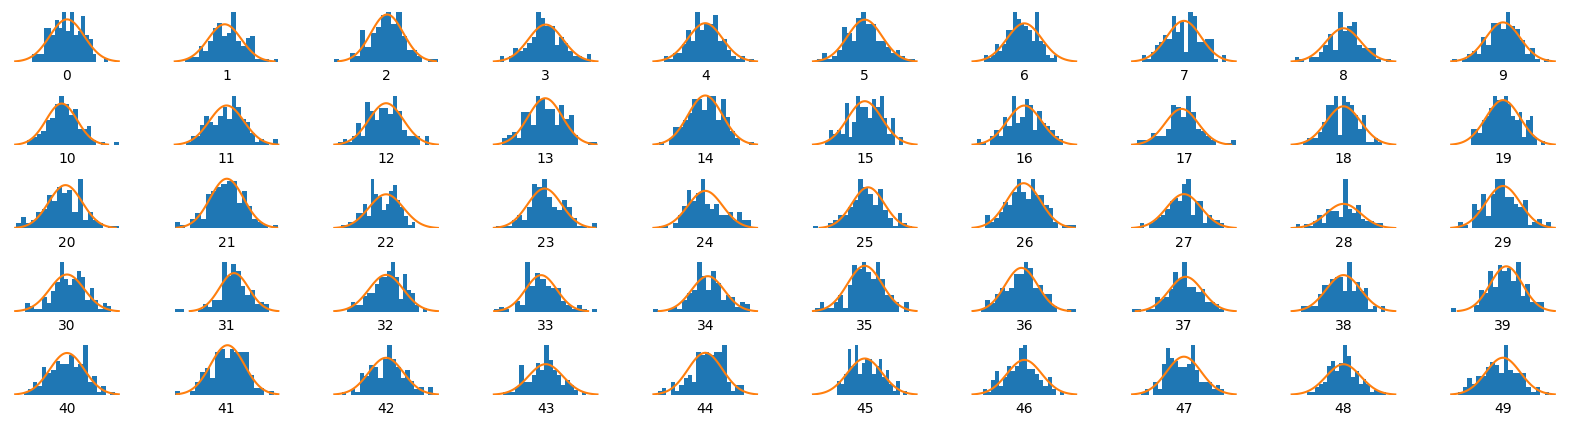

In [21]:
_, _, z = vae.encoder.predict(example_images)

x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(z[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generate new faces <a name="decode"></a>

In [22]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [23]:
# Decode the sampled points
reconstructions = decoder.predict(z_sample)

1/1 [==============================] - 0s 212ms/step


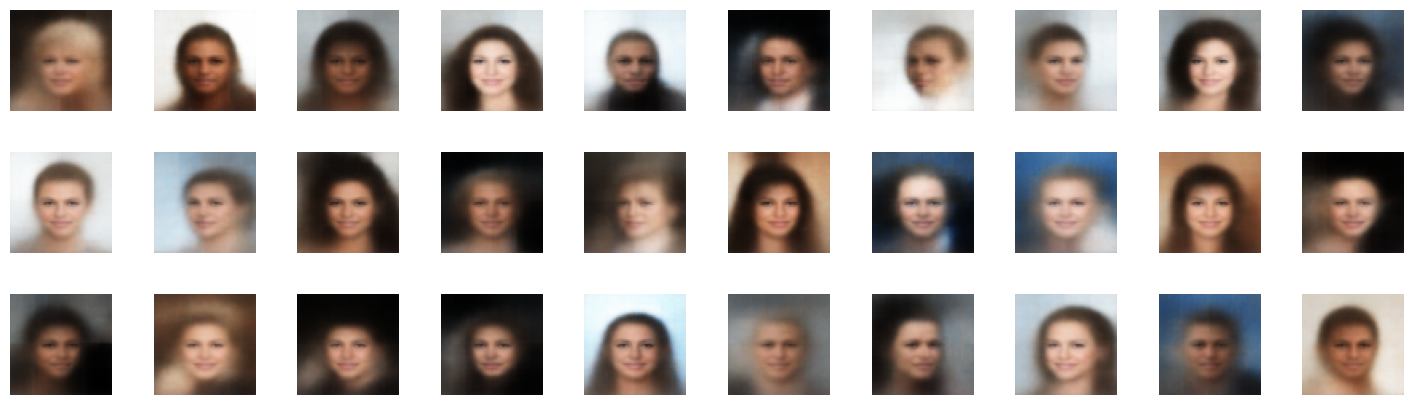

In [24]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images <a name="manipulate"></a>

In [25]:
# Load the label dataset
csvFile = dataFolder + "/list_attr_celeba.csv"
attributes = pd.read_csv(csvFile)
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [26]:
# Load the face data with label attached
LABEL = "Blond_Hair"  # <- Set this label
labelled_test = utils.image_dataset_from_directory(
    dataFolder,
    labels=attributes[LABEL].tolist(),
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

labelled = labelled_test.map(lambda x, y: (preprocess(x), y))

Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [27]:
# Find the attribute vector
attribute_vec = get_vector_from_label(labelled, vae, Z_DIM, LABEL)

label: Blond_Hair
images : POS move : NEG move :distance : 𝛥 distance
22    : 3.493    : 1.438    : 3.876    : 3.876
44    : 2.198    : 0.958    : 2.86    : -1.016
65    : 1.103    : 0.557    : 2.357    : -0.503
87    : 0.863    : 0.399    : 2.023    : -0.334
110    : 0.684    : 0.296    : 1.948    : -0.075
128    : 0.492    : 0.251    : 1.873    : -0.075
150    : 0.498    : 0.195    : 1.806    : -0.066
171    : 0.36    : 0.189    : 1.776    : -0.03
197    : 0.344    : 0.166    : 1.764    : -0.012
218    : 0.344    : 0.149    : 1.708    : -0.056
241    : 0.288    : 0.13    : 1.676    : -0.031
260    : 0.243    : 0.122    : 1.682    : 0.006
282    : 0.221    : 0.104    : 1.669    : -0.013
302    : 0.223    : 0.104    : 1.629    : -0.04
317    : 0.174    : 0.093    : 1.62    : -0.009
337    : 0.192    : 0.087    : 1.597    : -0.023
356    : 0.185    : 0.091    : 1.568    : -0.029
377    : 0.168    : 0.077    : 1.562    : -0.006
395    : 0.149    : 0.074    : 1.546    : -0.017
415    : 0.

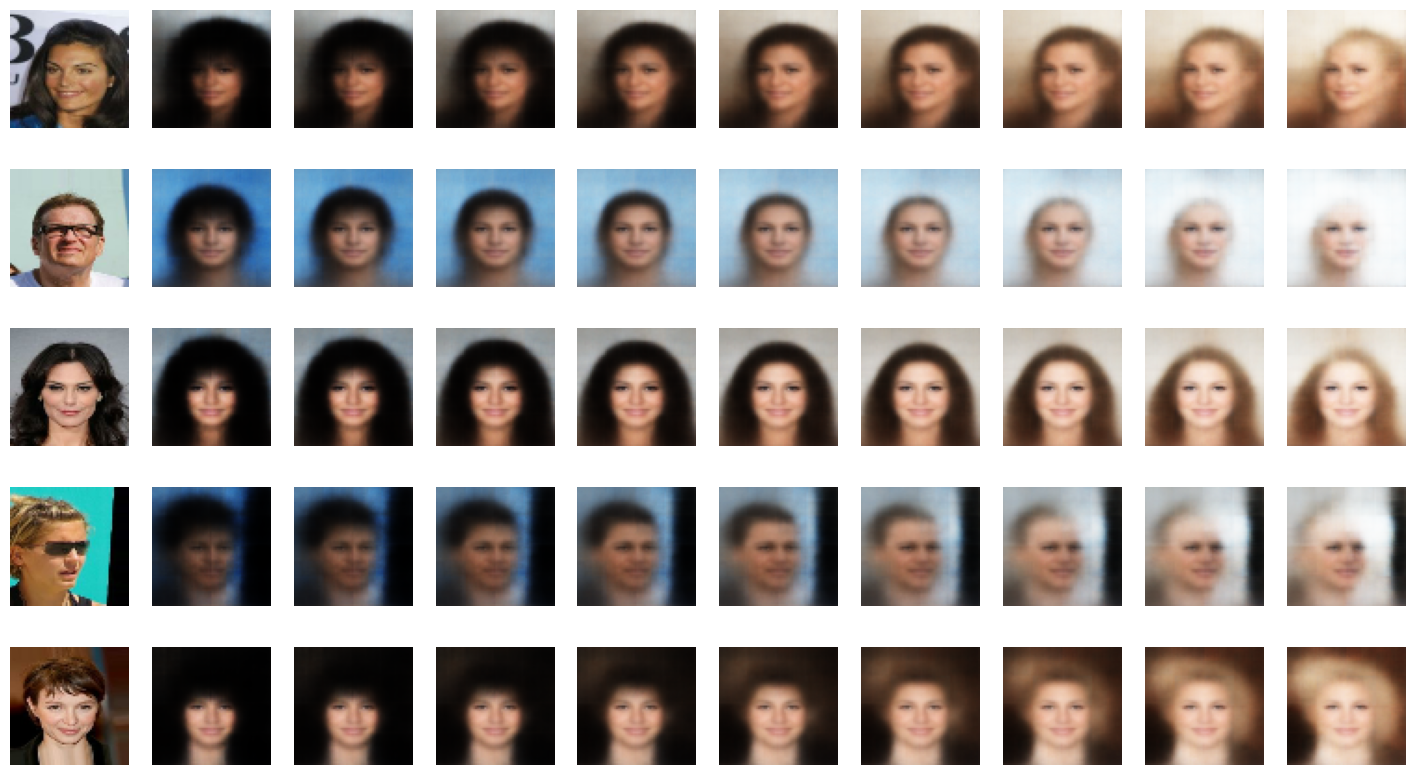

In [28]:
# Add vector to images
add_vector_to_images(labelled, vae, attribute_vec)

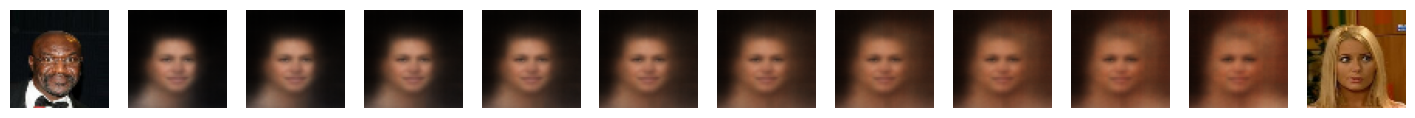

In [29]:
morph_faces(labelled, vae)

In [30]:
endTime = time.time()

elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")

# Run Date: Thursday, June 01, 2023
# Run Time: 00:11:25
